In [8]:
library(SingleCellExperiment)
library(scRNAseq)

library(ggplot2)
library(cowplot)
library(umap)

theme_set(theme_bw())

In [26]:
source("../R/rvp.R")
# source files
src_files <- list.files('../../relapse_prediction/R', full.names = TRUE)
for (f in src_files) {
  source(f)
  cat(sprintf('Sourced file: %s\n', f))
}

Sourced file: ../../relapse_prediction/R/batch.R
Sourced file: ../../relapse_prediction/R/calc.R
Sourced file: ../../relapse_prediction/R/misc.R
Sourced file: ../../relapse_prediction/R/normalise.R
Sourced file: ../../relapse_prediction/R/plot.R
Sourced file: ../../relapse_prediction/R/predict.R
Sourced file: ../../relapse_prediction/R/subset.R
Sourced file: ../../relapse_prediction/R/utils.R


# Villani
- Villani et al. (2017) - SmartSeq2 (no UMI tag)
- Description in Tran et al. (2020)
- TPM values are stored in file (discovery set)
- Metadata obtained from cell ID (768 cells used)
- 4 cell types, 2 batches
- Batch 1: Plates 7, 8, 9, 10; Batch 2: Plates 3, 4, 13, 14

In [4]:
file <- "../data/scrna/villani/processed/villani.rds"
villani <- readRDS(file)

In [11]:
rvp <- RVP.SingleCellExperiment(villani, "batch", "cell_type1", ret.obj = T)

In [14]:
SS <- rvp$sum_squares
# sort by ss_total
SS_t <- SS[order(-SS$ss_total), ]
# sort by ss_batch
SS_b <- SS[order(-SS$ss_batch), ]
# sort by mean
villani_counts <- assay(villani)
SS_m <- SS[order(-rowMeans(villani_counts)), ]
# sort by mean in top 10% cells
mean_counts_10 <- apply(villani_counts, 1, function(x) {
  pct <- 0.1
  mean(sort(x, decreasing = TRUE)[seq_len(pct * ncol(counts))])
})
SS_m10 <- SS[order(-mean_counts_10), ]

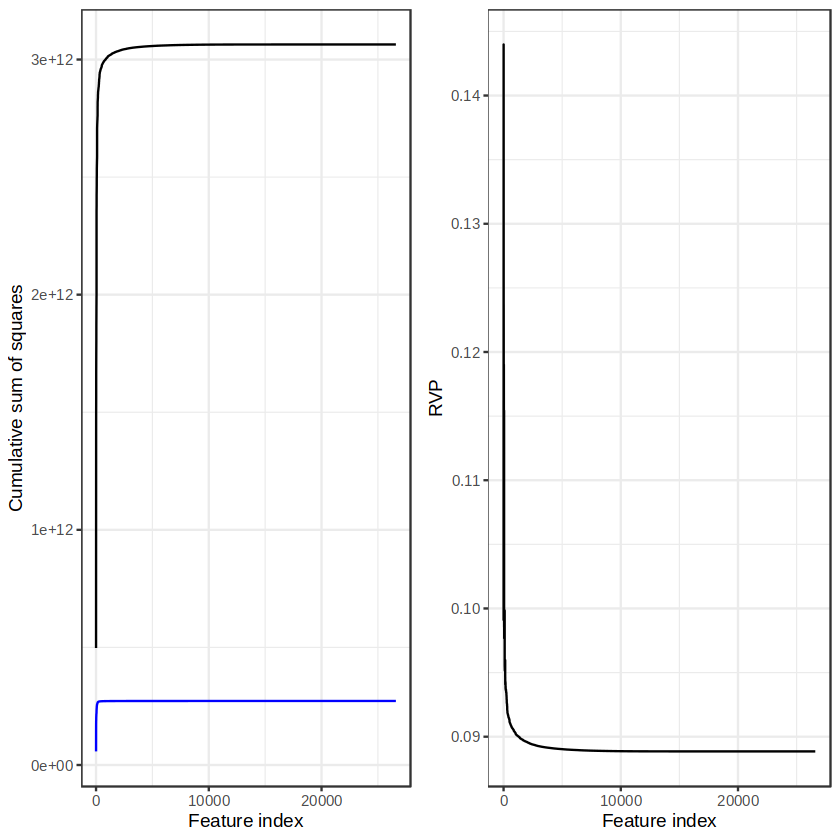

In [24]:
ax_rvp <- plot.rvp(SS_m10, cex = .5)
ax_rvp

file <- '~/Dropbox/tmp/ssm10-villani.pdf'
ggsave(file, ax_rvp, width = 6, height = 3)

#### Investigate

In [8]:
#' @param X Dataframe of dim (n_features, n_samples)
#' @param pct Minimum percentage of samples with value greater than zero
remove_features_dropout <- function(X, pct) X[rowSums(X > 0) >= pct * ncol(X), ]

#' @param X Dataframe of dim (n_features, n_samples)
#' @param pct Minimum percentage of samples with value greater than zero
remove_cells_lowcount <- function(X, pct) X[rowSums(X > 0) < pct * ncol]

[1] 16293   768

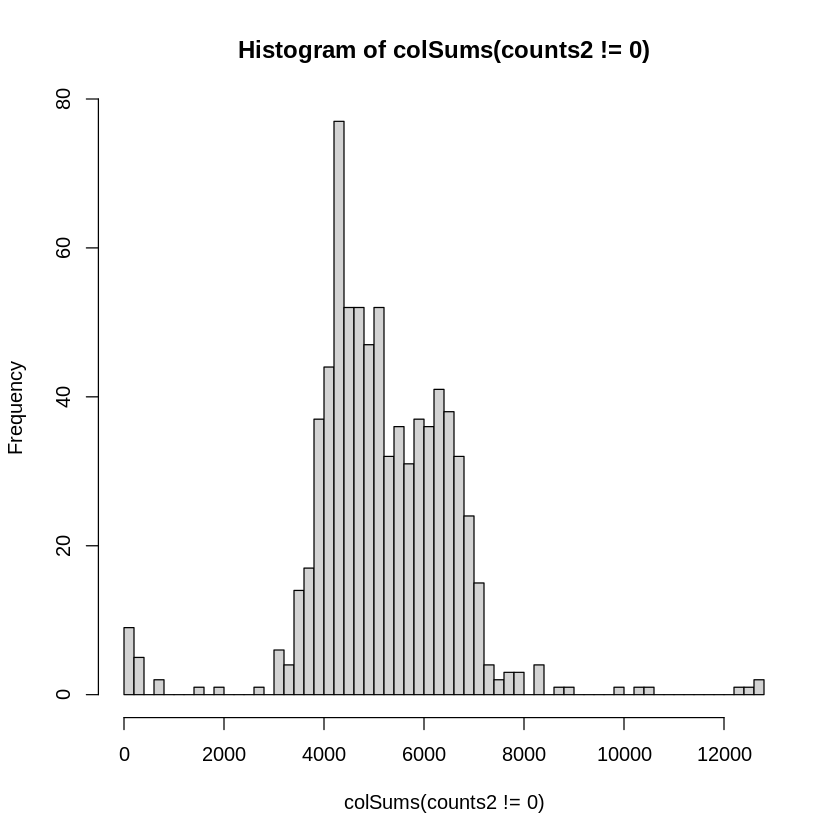

In [10]:
# filter features
counts2 <- remove_features_dropout(counts1, 0.01)
dim(counts2)

# filter doublets and empty cells
# low number of genes detected or low total counts
# filter cells with enriched mitochondrial rna
hist(colSums(counts2 != 0), breaks = 50)
# TODO: Inspect cells with detected < 2000

In [28]:
rvp1 <- RVP(t(counts1), coldata$batch, coldata$celltype, ret.obj = TRUE)
rvp2 <- RVP(t(counts2), coldata$batch, coldata$celltype, ret.obj = TRUE)

In [17]:
rvp <- RVP(t(counts2), coldata$batch, coldata$celltype, ret.obj = TRUE)
SS <- rvp$sum_squares

### Plots: PCA

In [28]:
coldata <- colData(villani)
ax_pca <- ggplot_pca(counts, coldata, col = 'batch', pch = 'cell_type1') +
  labs(subtitle = sprintf("RVP = %.4f", rvp$percentage))
ax_pca

ERROR: Error: subscript contains invalid names


In [55]:
file <- '~/Dropbox/tmp/pca-villani.pdf'
ggsave(file, ax2, width = 6, height = 4)